In [81]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
import seaborn as sns

import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix


import graphviz

In [2]:

url = r'C:\Users\Anton\Documents\Anton_Gollbo\Skolarbete\STS4\SML\data\training_data.csv'
url2 = r'C:\Users\Anton\Documents\Anton_Gollbo\Skolarbete\STS4\SML\data\songs_to_classify.csv'
df_songs_training = pd.read_csv(url, dtype={'ID': str}).dropna().reset_index(drop=True)
df_songs_test = pd.read_csv(url2, dtype={'ID': str}).dropna().reset_index(drop=True)



# 0. Always predicting Person to like a given song
### Will give us some reference value to "compete" against

In [3]:
df_model = df_songs_training.copy()
x = df_model.drop(columns=['label'])
y = df_model['label']

prediction = np.ones(y.shape[0])

always_like_prediction_acc = accuracy_score(y,prediction)
print(always_like_prediction_acc)

0.6026666666666667


# 0.1 Explore given data


array([[<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'energy'}>],
       [<AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'time_signature'}>],
       [<AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'label'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

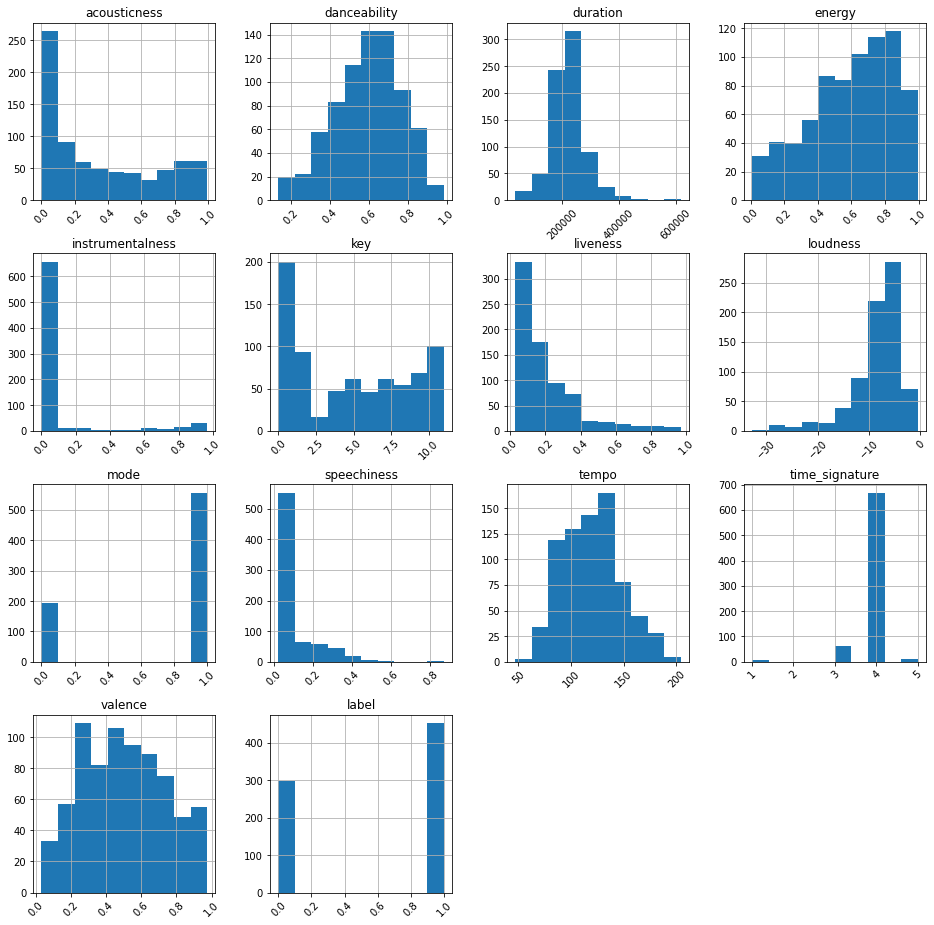

In [117]:
df_songs_training.describe()
df_songs_training.shape
df_songs_training.head()
#Show distribution of values through a histogram
df_songs_training.hist(figsize=(16,16), xrot=45)




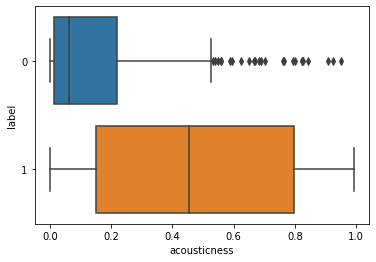

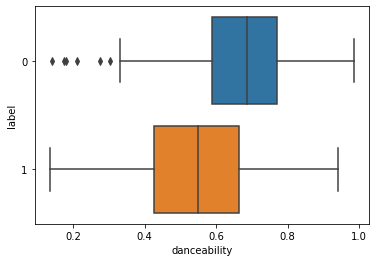

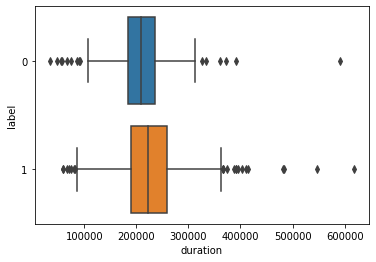

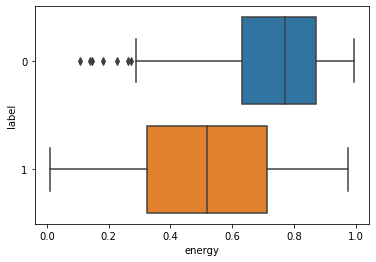

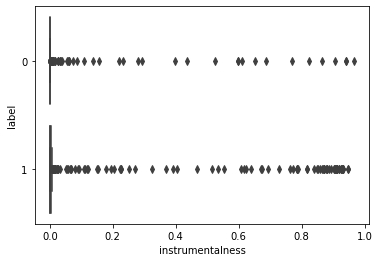

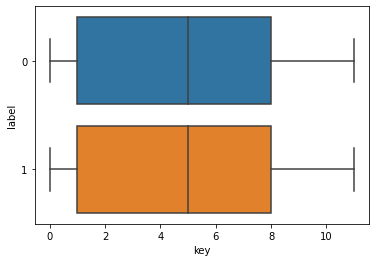

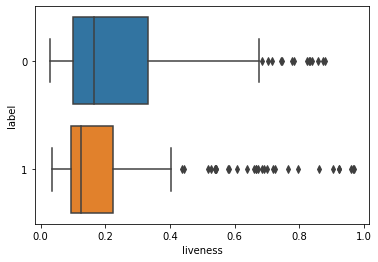

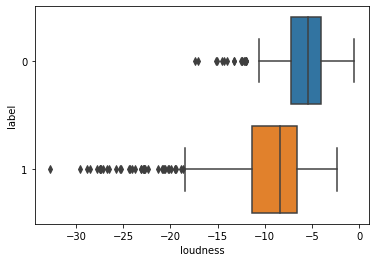

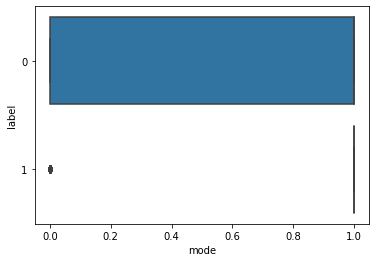

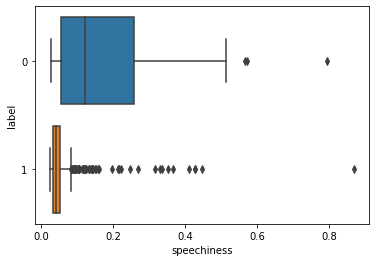

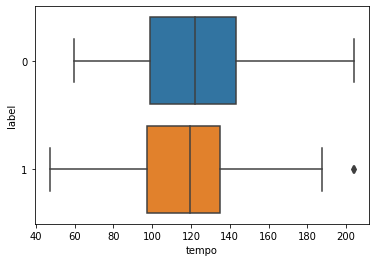

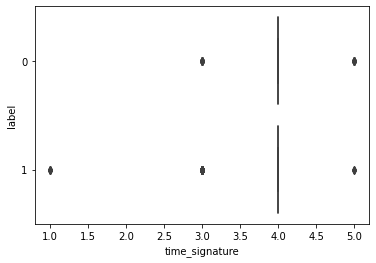

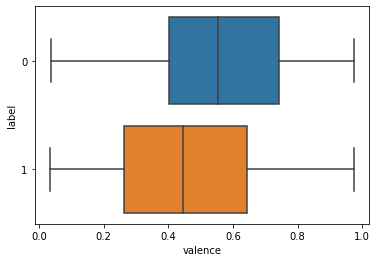

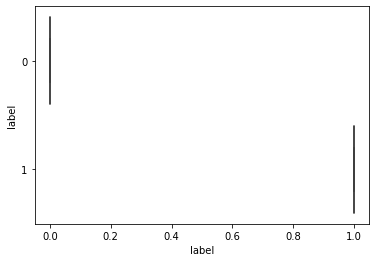

In [118]:
#Use boxplots to show how the distribution of the different columns values impact the labels, from this we can see some 
#columns may be better fit to use in our model and others might not be as good
num_cols = df_songs_training.columns
for col in num_cols:
    sns.boxplot(y = df_songs_training['label'].astype('category'), x = col, data=df_songs_training)
    plt.show()


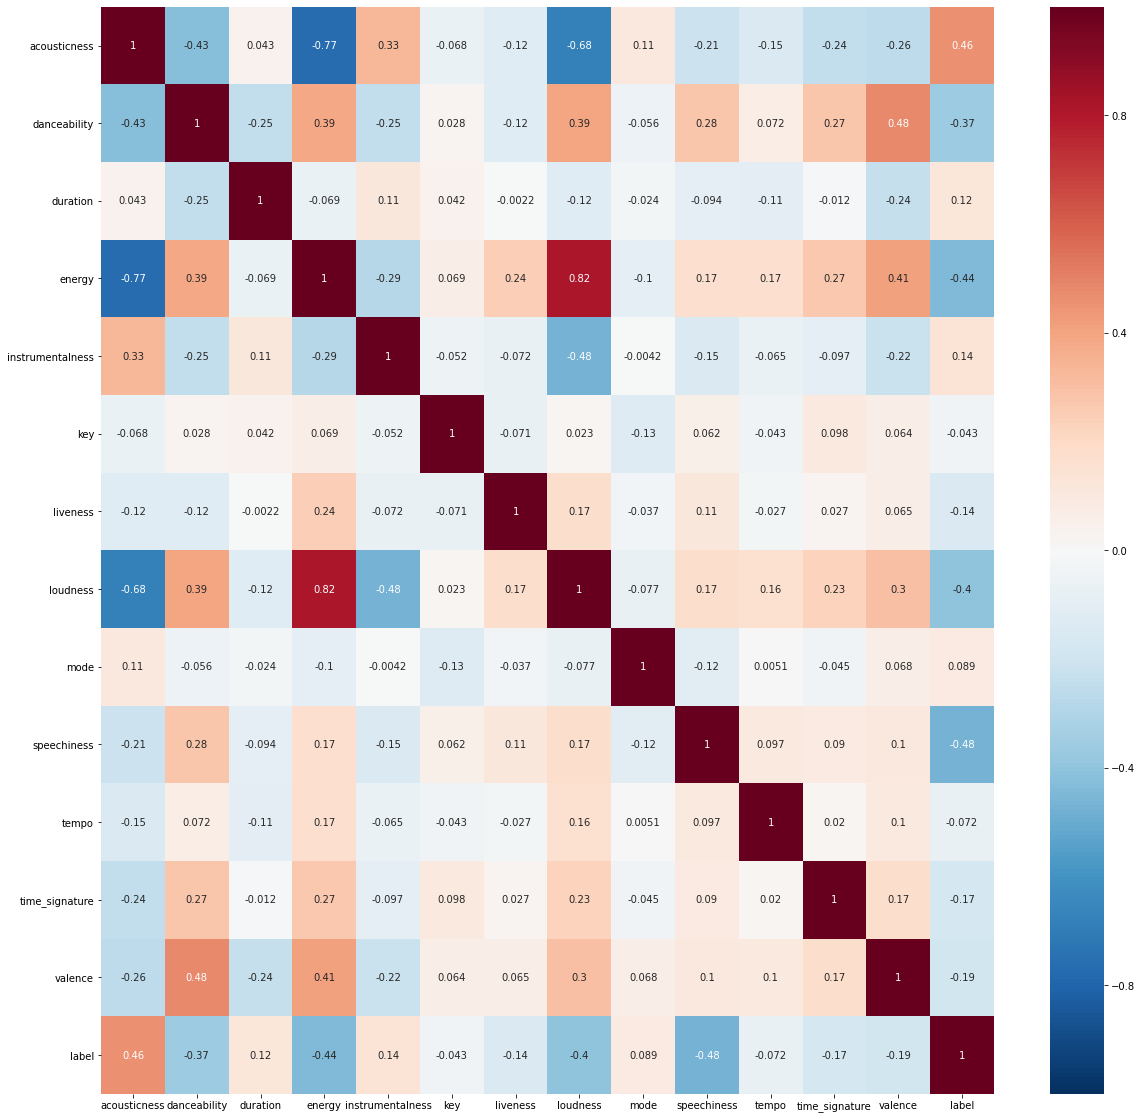

In [116]:
corr = df_songs_training.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

# 1. Random forest classifier 

## A random forest classifier is used, the feature selection is done by manually analyzing the boxplots above

### The boxplots suggest that the main features to look at are: ["acousticness", "danceability","energy", "loudness", "mode", "speechiness"]

The best depth was given by:  58  with accuracy:  0.8577777777777778


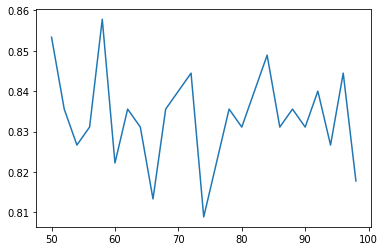

In [155]:
song_training = df_songs_training.copy()
observed_features = ["acousticness", "danceability","energy", "loudness", "mode", "speechiness"]

x = song_training[observed_features]
y = song_training["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

max_depths = range(50,100,2)
iteration_accuracy_dict = {}
for i in max_depths:
    rf_clf = RandomForestClassifier(max_depth = i)
    rf_clf.fit(x_train,y_train)

    y_pred = rf_clf.predict(x_test)
    iteration_accuracy = accuracy_score(y_test, y_pred)
    iteration_accuracy_dict[i] = iteration_accuracy

plt.plot(list(iteration_accuracy_dict.keys()),list(iteration_accuracy_dict.values()))

def get_key(val,my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
        
best_depth = get_key(max(iteration_accuracy_dict.values()), iteration_accuracy_dict)
print("The best depth was given by: ", best_depth, " with accuracy: ",max(iteration_accuracy_dict.values()))


## 1.1 RF evaluated using cross validation

### Random state is same as previous block, same n_estimator and max_depth is used

In [156]:
song_training = df_songs_training.copy()
observed_features = ["acousticness", "danceability","energy", "loudness", "mode", "speechiness"]

x = song_training[observed_features]
y = song_training["label"]

k = 10
kf = skl_ms.KFold(n_splits=k, shuffle=True)
best_mean = 0

accuracy_list = []

rf_clf = RandomForestClassifier(max_depth = best_depth)

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    rf_clf.fit(x_train,y_train)
    y_pred = rf_clf.predict(x_test)

    accuracy = accuracy_score(y_pred, y_test)
    accuracy_list.append(accuracy)

mean_acc = np.mean(accuracy_list)

print('accuracy of each fold  - {}'.format(accuracy_list))
print(f"Mean accuracy, with max_depth = {i}, is: " ,mean_acc)
    



accuracy of each fold  - [0.8133333333333334, 0.84, 0.8133333333333334, 0.7866666666666666, 0.8, 0.8, 0.8, 0.84, 0.84, 0.8266666666666667]
Mean accuracy, with max_depth = 98, is:  0.8160000000000001


# 2. KNN model with feature selection

## Feature selection is done using "ExtraTreesClassifier"

#### Earlier, I made an assumption that the most important features were the ones discovered during the exploratory data analysis in part 0.1. Here a different approach is used by using an ensemble learning method for feature selection. 

In [63]:
song_training = df_songs_training.copy()
x = song_training.drop(columns=['label'])
y = song_training['label']#Split data

iteration_accuracy_list = []
best_iteration_accuracies = {}

for num in range(5, 13):
    # "ExtraTreesClassifier" is chosen for features selection, with varying max_features to see how this affects the performance
    clf = ExtraTreesClassifier(n_estimators=num, criterion = "entropy", max_features = num)
    clf = clf.fit(x, y)
    clf.feature_importances_  

    top_features_from_fs = SelectFromModel(clf, prefit=True)
    model_using_fs = top_features_from_fs.transform(x)
    x_train, x_test, y_train, y_test = train_test_split(model_using_fs, y, test_size=0.3)

    best_accuracy = 0
    best_k = {}
    K = np.arange(1,100)

    for k in K:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(x_train, y_train)#Predict testing set
        y_pred = knn.predict(x_test)#Check performance using accuracy

        iteration_accuracy = accuracy_score(y_test,y_pred)
        iteration_accuracy_list.append(iteration_accuracy)


        if iteration_accuracy > best_accuracy:
            best_accuracy = iteration_accuracy
            best_iteration_accuracies[f"n_estimators_{num}"] = [iteration_accuracy]
            best_k[num] = k

    print("Best accuracy given k= ", best_k.values(), "with accuracy= ", best_accuracy, "and number of features= ", best_k.keys())

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best accuracy given k=  dict_values([9]) with accuracy=  0.7866666666666666 and number of features=  dict_keys([5])


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best accuracy given k=  dict_values([33]) with accuracy=  0.8088888888888889 and number of features=  dict_keys([6])


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best accuracy given k=  dict_values([12]) with accuracy=  0.8266666666666667 and number of features=  dict_keys([7])


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best accuracy given k=  dict_values([25]) with accuracy=  0.7866666666666666 and number of features=  dict_keys([8])


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best accuracy given k=  dict_values([23]) with accuracy=  0.84 and number of features=  dict_keys([9])


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best accuracy given k=  dict_values([3]) with accuracy=  0.7466666666666667 and number of features=  dict_keys([10])


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best accuracy given k=  dict_values([6]) with accuracy=  0.8177777777777778 and number of features=  dict_keys([11])


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Best accuracy given k=  dict_values([10]) with accuracy=  0.8044444444444444 and number of features=  dict_keys([12])


# 3. K-NN using feature selection and evaluated through cross validation

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


The best K-value is given at k =  4 which results in the accuracy:  0.7986666666666666


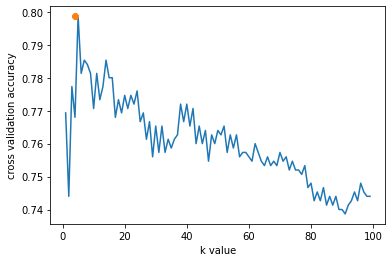

In [70]:
url = r'data\training_data.csv'
url2 = r'data\songs_to_classify.csv'
songTraining = pd.read_csv(url, dtype={'ID': str}).dropna().reset_index(drop=True)
songTest = pd.read_csv(url2, dtype={'ID': str}).dropna().reset_index(drop=True)

song_training = df_songs_training.copy()
#Split data into x and y
x = song_training.drop(columns=['label'])
y = song_training['label']

#Perform feature selection using ExtraTreesClassifier with max 9 features
clf = ExtraTreesClassifier(n_estimators=10, criterion = "entropy", max_features=7)
#Fit data according to selected important features
clf = clf.fit(x, y)
clf.feature_importances_  
#Create a model based on the feature selection 
model = SelectFromModel(clf, prefit=True)
X = model.transform(x)
#Define a cross validation object with 10 splits
crossVal = skl_ms.KFold(n_splits=10, shuffle = True)
newsplit = crossVal.split(X)
#
K = np.arange(1,100)

misclassifications = np.zeros(len(K))

for train_index, val_index in crossVal.split(X):
    X_train, X_validation = X[train_index], X[val_index]
    y_train, y_validation = y[train_index], y[val_index]
    #Standardize data with mean 0 and std 1
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_validation)
    
    for j,k in enumerate(K):
        kNNModel = skl_nb.KNeighborsClassifier(n_neighbors = k)
        kNNModel.fit(X_train,y_train.values.ravel())
        kNNpredict = kNNModel.predict(X_validation)
        kNNpredict = kNNpredict.reshape(kNNpredict.size,1)
        misclassifications[j] += accuracy_score(y_validation,kNNpredict)
        
misclassifications /= 10 
plt.plot(K, misclassifications)
plt.plot(np.argmax(misclassifications),max(misclassifications), marker="8")
plt.xlabel("k value")
plt.ylabel("cross validation accuracy")
best_k = np.argmax(misclassifications)
print("The best K-value is given at k = ", best_k, "which results in the accuracy: ",  max(misclassifications))



# 4. Multilayer perceptron test

## Using ExtraTreesClassifier for features selection


In [77]:
song_training = df_songs_training
x = song_training.drop(columns=['label'])
y = song_training['label']#Split data

clf = ExtraTreesClassifier(n_estimators=10, criterion = "entropy")
clf = clf.fit(x, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X = model.transform(x)

accuracies = []
mlps = []
iterations = np.arange(1,10);

for i in iterations:
    X_train, X_validation, y_train, y_validation = skl_ms.train_test_split(X,y, test_size = 0.3)
    mlp = MLPClassifier(hidden_layer_sizes=(10,5),max_iter=5000)
    mlps.append(mlp.fit(X_train, y_train))
    predictions = mlp.predict(X_validation)
    iteration_accuracy = accuracy_score(y_validation,predictions)
    accuracies.append(iteration_accuracy)

print(accuracies)

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[0.6, 0.8133333333333334, 0.84, 0.8177777777777778, 0.84, 0.8533333333333334, 0.8266666666666667, 0.8488888888888889, 0.84]


## 4.1 MLP using feature selection and evaluated through cross validation

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Average accuracy: 0.7893333333333332 Highest accuracy:  0.8533333333333334 Lowest accuracy:  0.64 STD:  0.06162250671088717
Accuracies:  [0.64, 0.7866666666666666, 0.7333333333333333, 0.8266666666666667, 0.84, 0.7733333333333333, 0.7733333333333333, 0.84, 0.8266666666666667, 0.8533333333333334]


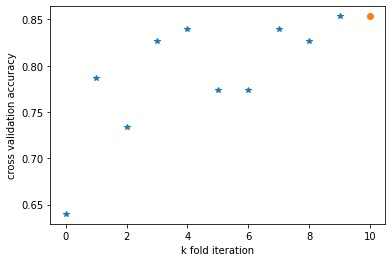

In [123]:
df_model = songTraining.copy()
x = df_model.drop(columns=['label'])
y = df_model['label']#Split data

clf = ExtraTreesClassifier(n_estimators=10, criterion = "entropy", max_features=9)
clf = clf.fit(x, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X = model.transform(x)
#splits = 10
misclassifications = np.zeros(splits)
accuracies_new = []
layer_size = (10,5)
iterations = 0
crossVal = skl_ms.KFold(n_splits=splits,shuffle = True)
newsplit = crossVal.split(X)

best_model = 0
best_acc = 0

for train_index, val_index in crossVal.split(X):
    iterations = iterations+1
    X_train, X_validation = X[train_index], X[val_index]
    y_train, y_validation = y[train_index], y[val_index]
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    mlpModel = MLPClassifier(hidden_layer_sizes= layer_size, max_iter = 5000)
    mlpModel.fit(X_train, y_train)
    mlpPredict = mlpModel.predict(X_validation)
    iteration_accuracy = accuracy_score(y_validation,mlpPredict)
    accuracies_new.append(iteration_accuracy)
    
    if iteration_accuracy > best_acc:
        best_acc = iteration_accuracy
        best_model = mlpModel   


print("Average accuracy:", np.mean(accuracies_new), "Highest accuracy: ", max(accuracies_new), "Lowest accuracy: ", min(accuracies_new), "STD: " , np.std(accuracies_new))
print("Accuracies: ", accuracies_new)

best_model_predict = best_model.predict(X)
best_model_accuracy = accuracy_score(y, best_model_predict)
confusion_matrix(y, best_model_predict)

best_index = np.argmax(accuracies_new)
plt.plot(range(0,iterations), accuracies_new,"*")
plt.plot(best_index+1, accuracies_new[best_index],marker="8")
plt.xlabel("k fold iteration")
plt.ylabel("cross validation accuracy")
plt.show()

# 5. Choosing the final model: Random Forest

## Random forest produced high accuracy results consistently, therefore it is chosen as the final model in this project.

### The final task is to predict on a separate data set, this one is not possible to validate, as it was done through submittal through the course.

In [159]:
song_training = df_songs_training.copy()
song_testing = df_songs_test.copy()
observed_features = ["acousticness", "danceability","energy", "loudness", "mode", "speechiness"]

x_train = song_training[observed_features]
y_train = song_training["label"]

x_test = song_testing[observed_features]
y_test = song_training["label"]


rf_clf = RandomForestClassifier(max_depth = best_depth)
rf_clf.fit(x_train,y_train)

y_pred = rf_clf.predict(x_test)

print(y_pred)

[1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1
 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1
 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1
 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1
 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0]
